# Three-input models

![image-4](image-4.png)


In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense, Embedding, Input, Flatten
from tensorflow.keras.models import Model

2023-05-30 05:08:08.217658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-30 05:08:08.217682: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Read the data 
games_season = pd.read_csv('datasets/games_season.csv')
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [3]:
games_tourney = pd.read_csv('datasets/games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [4]:
unique_teams = games_season['team_1'].unique().shape[0]
unique_teams

10888

In [5]:
# Create a lookup model that's shared by the input layer

# Create layers
input_layer = Input(shape=(1,))

embedding_layer = Embedding(input_dim=unique_teams, 
                            output_dim=1, 
                            input_length=1)(input_layer)

flatten_layer =  Flatten()(embedding_layer)

# Create model
team_strength_model = Model(input_layer, flatten_layer)

2023-05-30 05:08:09.855364: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-30 05:08:09.855385: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-30 05:08:09.855399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (19a8477c-1ee5-4228-b4aa-1cfddec36545): /proc/driver/nvidia/version does not exist
2023-05-30 05:08:09.855572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from tensorflow.keras.layers import Concatenate

# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [7]:
# Import the model class
from tensorflow.keras.models import Model

# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

**The model looks similar to:**

![image-5](image-5.png)

In [8]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=0.1,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']], games_tourney['score_diff'], verbose=False))

138/138 [==============================] - 1s 2ms/step - loss: 12.2519 - val_loss: 11.6796
11.686132431030273


# Summarizing and plotting models

In [9]:
# Summarize the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Team-1-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-2-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 1)            10888       ['Team-1-In[0][0]',              
                                                                  'Team-2-In[0][0]']              
                                                                                                  
 Home-In (InputLayer)           [(None, 1)]          0           []                         

In [10]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


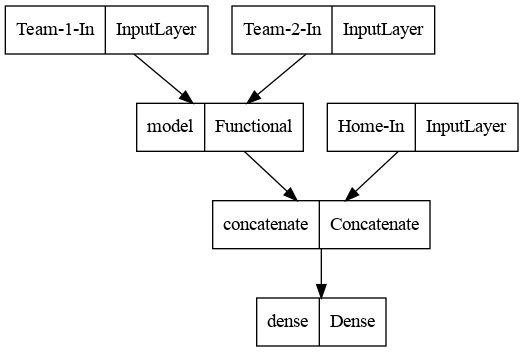

In [11]:
# Imports
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='model_3_inputs.png')


# Stacking models
- "Model Stacking" or using the predictions from one model as an input to another model. 
- Model stacking is a very advanced data science concept. It is the most sophisticated way of combining models, and when done right can yield some of the most accurate models in existence. Model stacking is often employed to win popular predictive modeling competitions.

![image-9](image-9.png)

- This diagram shows the process for stacking these 2 models. You start with the regular season dataset and fit a model to it. You then predict on the tournament dataset, using this model. This gives you predicted tournament outcomes, which you can now use to build a better model of the actual tournament outcomes.

In [16]:
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [13]:
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [14]:
# Use this model to predict the score_diff for each team based on Team IDs and either its home or not and add to the tournament data

# Predict
games_tourney['pred'] = model.predict([games_tourney['team_1'],games_tourney['team_2'], games_tourney['home']])


133/133 [==============================] - 0s 625us/step


In [15]:
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,pred
0,1985,288,73,0,-3,-9,41,50,0,0.088814
1,1985,5929,73,0,4,6,61,55,1,0.086353
2,1985,9884,73,0,5,-4,59,63,0,0.085297
3,1985,73,288,0,3,9,50,41,1,0.109383
4,1985,3920,410,0,1,-9,54,63,0,0.100295


The prediction from the regular season model captures the effects of team_1 and team_2, which means you now don't need to use those two variables in the tournament model, and can avoid the use of an embedding layer. You can focus your modeling efforts on the purely numeric data, which is a little easier to work with. With purely numeric inputs, you can pass all of them to a single input layer.

In [21]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [22]:
# Fit the model
model.fit(games_tourney[['home', 'seed_diff', 'pred']],
          games_tourney['score_diff'],
          epochs=10,
          verbose=True,
         validation_split=0.2)

Epoch 1/10
106/106 [==============================] - 0s 2ms/step - loss: 9.7110 - val_loss: 9.3790
Epoch 2/10
106/106 [==============================] - 0s 924us/step - loss: 9.5487 - val_loss: 9.2839
Epoch 3/10
106/106 [==============================] - 0s 1ms/step - loss: 9.4189 - val_loss: 9.2260
Epoch 4/10
106/106 [==============================] - 0s 948us/step - loss: 9.3179 - val_loss: 9.1898
Epoch 5/10
106/106 [==============================] - 0s 923us/step - loss: 9.2467 - val_loss: 9.1735
Epoch 6/10
106/106 [==============================] - 0s 943us/step - loss: 9.1980 - val_loss: 9.1774
Epoch 7/10
106/106 [==============================] - 0s 929us/step - loss: 9.1723 - val_loss: 9.1875
Epoch 8/10
106/106 [==============================] - 0s 935us/step - loss: 9.1512 - val_loss: 9.1983
Epoch 9/10
106/106 [==============================] - 0s 913us/step - loss: 9.1373 - val_loss: 9.2108
Epoch 10/10
106/106 [==============================] - 0s 902us/step - loss: 9.1289 - 